# Programming and Tools for AI (/ Online / CA) - CT5132 / CT5148 / CT5229

# Assignment 2: Melody Graph

Let's say we are musicologists, and we want to study how melodies have changed and evolved over time.

We have a collection of melodies, and each melody has a date when we know it was composed. 

Each melody is a sequence of notes (integers). We are given the years and melodies, one per line, in a file `melody_graph_dataset.txt`, in this format:

```
1900: [4, 6, 1, 3]
1901: [4, 4, 1, 3]
1902: [4, 6, 1, 2, 3]
```

Some melodies are composed from scratch. But sometimes, a composer learns a previous melody, and composes a new version of the same melody, with some changes. 
Changes consist of:

* Inserting a note
* Removing a note
* Changing a note. 

The number of such changes between two melodies is calculated by Edit Distance (ED). 

* The 1900 and 1901 melodies differ by ED 1, because we can change one to the other by changing the 6 to a 4. 
* The 1900 and 1902 melodies differ by ED 1, because we can insert a 2. 
* The 1901 and 1902 melodies differ by ED 2, because we have to change 4 to 6 and insert a 2 (or the other way around, as ED is symmetric: ED is still 2, because we have to change 6 to 4 and remove a 2).

ED (also known as Levenshtein distance) is calculated using an interesting technique called Dynamic Programming which we will not study in this module. You don't need to implement ED or explain how it is calculated internally. To use ED we can install a library: `pip install editdistance`. 

If a melody differs by 4 or more changes from every older melody, we assume it is a new melody. Otherwise, we assume it was created by a composer changing an older melody, and in fact we assume it was by changing whichever older melody it is most similar to. 

When a melody is created by copying and changing an older melody, we call them `parent` (the original) and `child` (the new, changed one).

We will take in the dataset (melodies together with their dates), and form the directed graph in which melodies are nodes, and the "copy-change" relationship is represented by `parent` and `child` links as in the example below. We will then use lots of functions for analysis of the dataset.

```
G = {
  0: {'year': 1900, 'melody': (4, 6, 1, 3),    'parent': None, 'children': [1, 2]} # this is a "new melody"
  1: {'year': 1901, 'melody': (4, 4, 1, 3),    'parent': 0,    'children': []    } # this melody was formed by editing melody 0
  2: {'year': 1902, 'melody': (4, 6, 1, 2, 3), 'parent': 0,    'children': []    } # this melody was formed by editing melody 0
}
```

Every melody should be given a `node_id` when we add it to the graph, which is sequential from 0.

We will add the melodies in order of date, so we never need to check whether the current melody is a `parent` of a previous melody. We only check whether it is a `child` of a previous one.

Multiple melodies may have the same date.

A melody may have multiple children, but only one parent.

For this assignment we can use pure Python and/or the NetworkX library, as you prefer.

For this assignment, the application is musicology, but you don't need to know anything about music or musicology to do this. Everything you need to know about music is already written in this notebook. DO NOT start researching music before doing this assignment.

# Tasks

Your job is to add code in the notebook where indicated with YOUR CODE HERE. A lot of code is given already, and should not be changed. Don't change the signature (ie number and type of arguments, and return type) of each function. All of your code should be inside functions inside `MelodyGraph`. Your code should not `print` anything. Be careful to use `return` or `yield` where required. Look carefully at the **Expected results** section: it shows some code that uses our `MelodyGraph`, and the results expected. Don't change the code in this section.

In [390]:
# pip install editdistance # uncomment if needed

In [391]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm 
from sklearn.manifold import TSNE
import editdistance

from editdistance import editdistance # Read in the editdistance fucntion that was provided

In [392]:
class MelodyGraph:
    def __init__(self, filename=None):
        self.nodes = {} # {node_id: {'melody': melody, 'year': year, 'parent': parent_id, 'children': [id0, id1, ...]} }
        self.next_id = 0 # each melody gets a unique id starting from 0
        if filename:
            self.read_data(filename)

    def read_data(self, filename): # we assume the data is sorted by year
        """Read in the data in the given format, eg:     
        1900: [4, 6, 1, 3]
        1901: [4, 4, 1, 3]
        1902: [4, 6, 1, 2, 3]
        """
        # YOUR CODE HERE. READ THE DATA AND RUN add_melody() FOR EACH LINE. APPROX 7 LINES.
        with open(filename) as f:
            for line in f:
                year, melody = line.strip().split(": ")
                self.add_melody(melody=eval(melody), year=year)

    
    def add_melody(self, melody, year, margin=4):
        """Add melody, automatically finding parent if similar enough"""
        # Find best parent candidate
        # Add node with parent link if appropriate
        # Return node id
        
        # YOUR CODE HERE. APPROX 20 LINES.
        
        # Build the nodes
        self.nodes[self.next_id] = {'melody':melody, 'year':year, 'parent':None, 'children':[]}
        similar_id = []
        similarity = []
        
        if self.next_id != 0:
            for node_id in self.nodes:
                if node_id == self.next_id: continue

                diff = editdistance(self.nodes[node_id]['melody'], melody)
               
                if diff < margin:
                    similar_id.append(node_id)
                    similarity.append(diff)

            if len(similarity) != 0:
                # https://www.geeksforgeeks.org/python/python-ways-to-sort-a-zipped-list-by-values/
                # Used the sorting in place by seocnd element from geeksforgeeks.
                zipped_list = list(zip(similar_id, similarity))
                # sort by similarity
                zipped_list.sort(key=lambda x: x[1])

                # Add parent to the current node and Add current node as child to the parent
                self.nodes[self.next_id]['parent'] = zipped_list[0][0]
                self.nodes[zipped_list[0][0]]['children'].append(self.next_id)
        self.next_id += 1
        
    def get_ancestry(self, node_id):
        """Yield path from node to root, including node itself and root itself, one node at a time"""
        # YOUR CODE HERE. APPROX 3 LINES
        while node_id is not None:
            yield node_id
            node_id = self.nodes[node_id]['parent']
    
    def get_longest_ancestry(self):
        """Return the longest ancestry, ie longest path from node to root"""
        # THIS FUNCTION IS COMPLETE, DON'T CHANGE IT
        return max((list(self.get_ancestry(i)) for i in self.nodes), 
                   key=lambda x: len(x))    
        
    def get_descendants(self, node_id):
        """Yield all descendants of a given node, including itself, recursively"""
        # YOUR CODE HERE. APPROX 3 LINES
        # Used Anthropic Claude Sonnet 4.5: I used it to help understand how I can yield the recursive function and loop through all the children.
        if node_id is None: return
        yield node_id
        for child in self.nodes[node_id]['children']:
            yield from self.get_descendants(child)
    
    def get_roots(self):
        """Yield all original melodies"""
        # YOUR CODE HERE. APPROX 3 LINES
        for node_id in self.nodes:
            if self.nodes[node_id]['parent'] is None:
                yield node_id

    def get_families(self):
        """Yield all families, in the format (node_id, list_of_descendents)"""
        # THIS FUNCTION IS COMPLETE, DON'T CHANGE IT
        for root in self.get_roots():
            yield (root, list(self.get_descendants(root)))
        
    def get_largest_family(self):
        """Return the single largest family - just the node IDs"""
        # YOUR CODE HERE. APPROX 1 LINE
        return max(self.get_families(), key=lambda x: len(x[1]))[1]
    
    def get_most_copied(self):
        """Return the node which was directly copied the most, ie most direct children"""
        return max(self.nodes, key=lambda n: len(self.nodes[n]['children']))
    
    def get_all_years(self):
        """Yield the year of each melody, which may include duplicate years"""
        # YOUR CODE HERE. APPROX 1 LINE
        yield from (int(self.nodes[node_id]['year']) for node_id in self.nodes)
    
    def get_shortest_melody(self):
        """Return the single shortest melody - just the melody itself"""
        # THIS FUNCTION IS COMPLETE
        return min((self.nodes[node_id]['melody'] for node_id in self.nodes), key=len)
    
    def get_longest_melody(self):
        """Return the single longest melody - just the melody itself"""
        # THIS FUNCTION IS COMPLETE
        return max((self.nodes[node_id]['melody'] for node_id in self.nodes), key=len) 

    def get_melodies_which_were_copied(self):
        """Yield melodies which have at least one child"""     
        # YOUR CODE HERE. APPROX 3 LINES
        for node_id in self.nodes:
            if len(self.nodes[node_id]['children']) > 0:
                yield node_id

    def get_melodies_never_copied(self):
        """Yield any melodies with no children. A leaf is a node in a tree with no children."""
        # THIS FUNCTION IS COMPLETE
        for node_id in self.nodes:
            if len(self.nodes[node_id]['children']) == 0:
                yield node_id

    def histogram_years(self, nbins=10):
        """Get the year of every melody and call matplotlib.hist to create a histogram"""
        # YOUR CODE HERE. APPROX 3 LINES. SEE EXPECTED OUTPUT BELOW - HISTOGRAM
        plt.hist(list(self.get_all_years()), bins=nbins)
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        
    def distance_matrix(self):
        """Create a distance matrix - a square, symmetric matrix,
        where element (i, j) is the ED between nodes i and j. However,
        use a special ordering of nodes so we can see the patterns in
        the data better. Call plt.imshow to see the matrix."""

        # we create a special *ordering* of the melodies
        ordering = [] # this is ordered by families, eg if we have two families containing melodies (0, 3, 4) and (1, 2) then ordering = [0, 3, 4, 1, 2]
        family_labels = [] # these labels help to group the families, eg in the above example, family_labels = [0, 0, 0, 1, 1]
        family_label = 0
        for root, members in self.get_families():
            ordering += members # a list of the node IDs in that family
            family_labels += [family_label] * len(members)
            family_label += 1

        # create the *distance matrix*, using the ordering above for rows and columns, so that nodes in the same family are in nearby rows and in nearby columns
        # YOUR CODE HERE. APPROX 8 LINES. 
        nodes_cnt = len(self.nodes)

        # Used ChatGPT 5 to help me with understanding how to creat the distance matrix
        # create a nodeXnode matrix
        dm = np.zeros((nodes_cnt, nodes_cnt))
        for i in range(nodes_cnt):
            for j in range(nodes_cnt):
                # Used ChatGPT 5 to help me with understanding how to creat the distance matrix variable.
                dm[i][j] = editdistance(self.nodes[ordering[i]]['melody'],
                                        self.nodes[ordering[j]]['melody'])    
        # YOUR CODE FOR DISTANCE MATRIX ENDS HERE.
    
        # now, use the dm we created above in imshow.
        plt.imshow(dm) # SEE EXPECTED OUTPUT BELOW - A SQUARE MATRIX WITH INTERESTING PATTERNS
        plt.colorbar()
        return dm, ordering, family_labels # useful to other functions

    def tsne_plot(self, dm, ordering, family_labels):
        """Run t-SNE to reduce our distance matrix to 2D, then scatterplot. Use ordering and family labels."""
        # YOUR CODE HERE. APPROX 8 LINES. SEE EXPECTED OUTPUT BELOW - NODE IDS AND COLURS
        #https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
        dm_transformed = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=7, random_state=42).fit_transform(dm)

        # https://stackoverflow.com/questions/52297857/t-sne-scatter-plot-with-legend
        dm_2d_one = dm_transformed[:, 0]
        dm_2d_two = dm_transformed[:, 1]
        plt.figure(figsize=(12,8))
        plt.scatter(x=dm_2d_one, y=dm_2d_two, c=family_labels)

        # https://stackoverflow.com/questions/57349722/how-can-i-add-labels-to-each-dot-on-my-scatter-plot-matplotlib
        for i, node_id in enumerate(ordering):
            plt.annotate(node_id, (dm_2d_one[i], dm_2d_two[i]), fontsize=8)
        

# Expected results

The following cells should not be changed. They call our `MelodyGraph` class and its functions, to create text output and images, as shown.

In [393]:
filename = "melody_graph_dataset.txt"
G = MelodyGraph(filename)
print(f'Longest ancestry: {G.get_longest_ancestry()}')
print(f'Most imitated: {G.get_most_copied()}')
print(f'Most imitated (all data): {G.nodes[G.get_most_copied()]}')
print(f'Largest family: {G.get_largest_family()}')
print(f'Shortest melody: {G.get_shortest_melody()}')
print(f'Longest melody: {G.get_longest_melody()}')
print(f'Melodies never copied: {list(G.get_melodies_never_copied())}')
print(f'Melodies which were copied: {list(G.get_melodies_which_were_copied())}')

# expected output:
# Longest ancestry: [62, 57, 55, 49, 47, 24]
# Most imitated: 1
# Most imitated (all data): {'melody': [7, 1, 3, 4, 4, 4, 4, 2, 6, 6, 8, 5, 3, 7], 'year': 1805, 'parent': None, 'children': [3, 8, 9, 18, 19]}
# Largest family: [24, 34, 38, 39, 50, 42, 36, 47, 49, 55, 57, 62, 56, 52]
# Shortest melody: [1, 4, 7, 1, 4, 8, 8, 4]
# Longest melody: [3, 5, 2, 8, 8, 8, 7, 7, 6, 2, 4, 1, 7, 7, 7, 8, 5, 4, 7, 6]
# Melodies never copied: [2, 3, 8, 9, 11, 13, 14, 15, 17, 18, 19, 21, 23, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 41, 42, 43, 44, 46, 48, 50, 51, 52, 53, 56, 61, 62, 63, 65, 66, 68, 69, 71, 73, 74, 75, 77, 78, 79]
# Melodies which were copied: [0, 1, 4, 5, 6, 7, 10, 12, 16, 20, 22, 24, 25, 26, 32, 34, 39, 40, 45, 47, 49, 54, 55, 57, 58, 59, 60, 64, 67, 70, 72, 76]

Longest ancestry: [62, 57, 55, 49, 47, 24]
Most imitated: 1
Most imitated (all data): {'melody': [7, 1, 3, 4, 4, 4, 4, 2, 6, 6, 8, 5, 3, 7], 'year': '1805', 'parent': None, 'children': [3, 8, 9, 18, 19]}
Largest family: [24, 34, 38, 39, 50, 42, 36, 47, 49, 55, 57, 62, 56, 52]
Shortest melody: [1, 4, 7, 1, 4, 8, 8, 4]
Longest melody: [3, 5, 2, 8, 8, 8, 7, 7, 6, 2, 4, 1, 7, 7, 7, 8, 5, 4, 7, 6]
Melodies never copied: [2, 3, 8, 9, 11, 13, 14, 15, 17, 18, 19, 21, 23, 27, 28, 29, 30, 31, 33, 35, 36, 37, 38, 41, 42, 43, 44, 46, 48, 50, 51, 52, 53, 56, 61, 62, 63, 65, 66, 68, 69, 71, 73, 74, 75, 77, 78, 79]
Melodies which were copied: [0, 1, 4, 5, 6, 7, 10, 12, 16, 20, 22, 24, 25, 26, 32, 34, 39, 40, 45, 47, 49, 54, 55, 57, 58, 59, 60, 64, 67, 70, 72, 76]


In [394]:
print("")
for root, members in G.get_families():
    print(members)

# expected output
# [0, 2, 7, 20, 27, 35, 11]
# [1, 3, 8, 9, 18, 19]
# [4, 6, 17, 10, 13, 15, 14, 16, 21]
# [5, 23, 31, 43, 46]
# [12, 26, 33, 41, 32, 37, 40, 51]
# [22, 28, 30, 48]
# [24, 34, 38, 39, 50, 42, 36, 47, 49, 55, 57, 62, 56, 52]
# [25, 44]
# [29]
# [45, 53]
# [54, 59, 66, 61, 73, 74]
# [58, 63, 64, 65, 71]
# [60, 68, 69]
# [67, 70, 75]
# [72, 76, 77, 78, 79]


[0, 2, 7, 20, 27, 35, 11]
[1, 3, 8, 9, 18, 19]
[4, 6, 17, 10, 13, 15, 14, 16, 21]
[5, 23, 31, 43, 46]
[12, 26, 33, 41, 32, 37, 40, 51]
[22, 28, 30, 48]
[24, 34, 38, 39, 50, 42, 36, 47, 49, 55, 57, 62, 56, 52]
[25, 44]
[29]
[45, 53]
[54, 59, 66, 61, 73, 74]
[58, 63, 64, 65, 71]
[60, 68, 69]
[67, 70, 75]
[72, 76, 77, 78, 79]


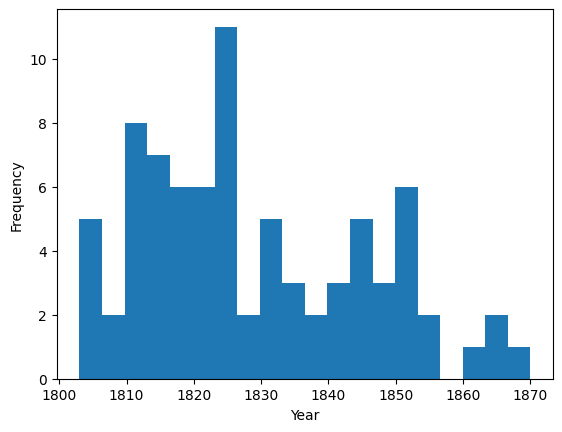

In [395]:
G.histogram_years(nbins=20)

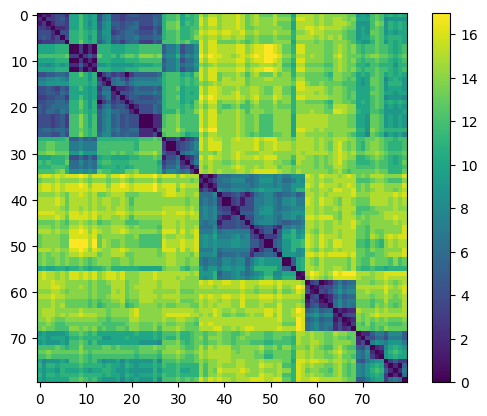

In [396]:
dm, ordering, family_labels = G.distance_matrix() # What patterns / structure do we see?

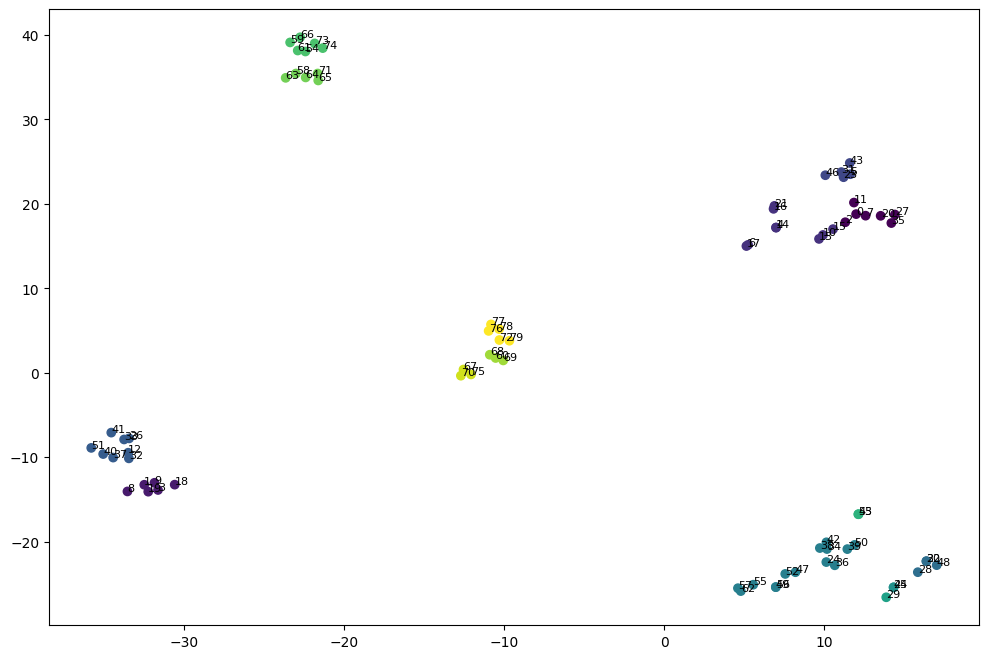

In [397]:
G.tsne_plot(dm, ordering, family_labels) # this shows the same as the distance matrix, in a different format

# Admin details

**Weight**: As announced on Canvas.

**Due date**: as announced on Canvas.

**Working**: Download the `.ipynb` file from Canvas, read it carefully, and follow the instructions. When finished, submit your `.ipynb` on Canvas. You are NOT required to work in Google Colab or share a Colab session with us, for this assignment.

**Groups**: you may work alone, or in a group of 2 of your choice. If in a group of 2, you must inform the lecturer of the group by email, cc-ing both members and including both members' names and ID numbers. You must send that email at least 2 weeks before the due date. And you must work together on all parts: you cannot divide the parts up between the group members. If in a group of 2, both students should make a submission and both should be identical. You cannot work together with a student you previously worked with, in this module or any other.

**Academic integrity**: you must submit only your own work. You may discuss the assignment with other students/groups, but may not show your work to others or allow others to see yours. You may use snippets of code sourced from the internet to solve specific sub-parts, but not entire solutions. In such a case, you must include a specific URL referring to each specific piece of code that you have used, directly above the code. A list of URLs at the bottom of the notebook is not acceptable. If you merely learn how to solve a problem by reading a webpage, you don't need to provide a citation.

**For this assignment, you MAY use AI code generators or other forms of AI**. However you must be able to explain every line of code you submit. Where you use AI, you should provide a detailed statement: which models you used, and how, for which specific parts of the assignment, dates, and prompts.

**Academic integrity: School policy and guidelines**: https://www.universityofgalway.ie/science-engineering/school-of-computer-science/currentstudents/academicintegrity/

**Grading**: Partial credit will be awarded for incomplete solutions. Comments should be used where needed, but straightforward code does not need a comment. I have indicated how long my code is in some places. You don't have to write code the same length. It's just intended as a rough guideline: if my code is 3 lines and yours is 30 lines, you might be going about it wrong way.

**Interviews**: after submission, some students/groups will be interviewed to check on their understanding of their own work. An inability to explain your own code may result in a grade penalty, a zero grade, or an academic integrity report.

**Required Acknowledgements and Details**. Please fill in appropriate values in the list below. If you don't fill in your student ID(s), name(s) and the appropriate answers to the questions below, we will not grade your submission.

* Student number(s): 25259253 
* Student name(s): Kacper Grzenda 
* Module code: MAI, ACS, MF, **MAO**, SPE, or PSD (2526-CT5148)
* I have read and understood the rules of the assignment: (**True** | False)
* I have shared or will share my code with other students: (True | **False**)
* I have provided a detailed statement about where and how I used AI: (**True** | False | Not applicable as I did not use AI)

# Interview

* The interview will consist of some basic questions about your code. The goal here is just to check that you understand what you have done.
* Eg, we will ask, how does this function work, what type is this variable, why did you do it this way.
* We may ask for interpretations of the outputs, both the printed outputs and the images.
* We will not ask questions which go beyond the code, like those below.


# Questions to think about

You don't have to implement anything here, but these are interesting things to think about. In CT5132/CT5148 (where we have an end-of-semester exam) there will be a question relating to this assignment.

* Consider `get_descendants`. It uses the `children` field. Suppose each node stored its `parent` only, ie didn't store `children`. Would it then be possible to write `get_descendents` in a different way? Would the graph use more or less memory? Would `get_descendents` be slower or faster?
* Suppose we had just the raw melody data, and no dates. Could we still use the same algorithms?
* In some of our code, we have the choice to return or yield a melody data structure (containing the melody, year, etc) or just to return the node ID. Which is better? What are the pros and cons?
* How many distance comparisons are required to add a dataset to the MelodyGraph?
* Suppose we discover a new melody $y$, and we realise the best place to add it would be as the child of some existing node $x$, and as the parent of some existing node $z$, ie we currently have the parent-child relationship $x-z$, but now we want to have instead $x-y-z$. Could we write code like that?
* Did you know that ED (and variants) are heavily used in bioinformatics, eg calculating similarity between strands of DNA? And the "parent-child" graph that we construct here is a simplified version of methods that are used in phylogenetic analysis, which is used to determine ancestry for other types of copy-change data, eg (1) ancient books being copied with occasional mistakes by monks in monasteries and (2) DNA being copied and changed during reproduction.
